In [1]:
# ! pip install hazm
# ! pip install gensim
# ! pip -q install clean-text[gpl]
# ! pip3 install transformers
# ! pip install pandas

In [2]:
import pandas as pd
import numpy as np
import re
from __future__ import unicode_literals
import hazm
import nltk
import codecs
import tqdm
import gensim
from cleantext import clean

C:\Users\Sajjad\.conda\envs\Training-Post-Retrieval\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Plot utils

In [3]:
# ! pip install arabic_reshaper
# ! pip install python-bidi
# ! pip install seaborn

In [4]:
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import seaborn as sns

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [6]:
def make_farsi_text(x):
    if x == 'الله':
        return 'هللا'
    reshaped_text = reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

### Load Data

In [7]:
with open('masnavi.txt', 'r', encoding="utf8") as infile:
    masnavi_file = infile.readlines()

In [8]:
stopwords = [x.strip() for x in codecs.open('stopwords.txt','r','utf-8').readlines()]

In [9]:
normalizer = hazm.Normalizer()

In [10]:
lemmatizer = hazm.Lemmatizer()

In [11]:
# Store Masnavi
masnavi = []

In [12]:
def remove_spaces_reg():
    # return space patterns
    space_pattern = r"[\xad\ufeff\u200e\u200d\u200b\x7f\u202a\u2003\xa0\u206e\u200c\x9d]"
    return re.compile(space_pattern)

In [13]:
def remove_symbols_reg():
    # return symbol patterns
    symbol_patterns = r"(\d|\"|'ٍ|¬|[؛“،,”‘۔’’‘–]|[|\.÷+\:\-\?»\=\{}\*«»_…\؟!/ـ]|[۰'ٓ۫'ٔ]|[ٓٔ]|[ًٌٍْﹼ،َُِّ«ٰ»ٖء])"
    return re.compile(symbol_patterns)

In [14]:
def remeove_arabic(text):
    # remove arabic alphabet
    mapping = {
        u"ۀ" : u"ه",
        "ة" : u"ت",
        "ي" : u"ی",
        "ؤ" : u"و",
        "إ" : u"ا",
        "ٹ" : u"ت",
        "ڈ" : u"د",
        "ئ" : u"ی",
        "ﻨ" : u"ن",
        "ﺠ" : u"ج",
        "ﻣ" : u"م",
        "ﷲ" : u"",
        "ﻳ" : u"ی",
        "ٻ" : u"ب",
        "ٱ" : u"ا",
        "ڵ" : u"ل",
        "ﭘ" : u"پ",
        "ﻪ" : u"ه",
        "ﻳ" : u"ی",
        "ٻ" : u"ب",
        "ں" : u"ن",
        "ٶ" : u"و",
        "ٲ" : u"ا",
        "ہ" : u"ه",
        "ﻩ" : u"ه",
        "ﻩ" : u"ه",
        "ك" : u"ک",
        "ﺆ" : u"و",
        "أ" : u"ا",
        "ﺪ" : u"د",
    }

    arabic_keys =  re.compile(r"(" + "|".join(mapping.keys()) + r")")
    return arabic_keys.sub(lambda x: mapping[x.group()], text)

In [15]:
# ! pip install parsivar

In [16]:
from parsivar import Tokenizer, FindStems, FindChunks, POSTagger

pars_tokenizer = Tokenizer()
pars_tagger = POSTagger(tagging_model="stanford")
pars_stem = FindStems()
pars_chunck = FindChunks()

In [17]:
spaces_reg = remove_spaces_reg() 
symbols_reg = remove_symbols_reg()
def clean_text(text, tokenize = False):
    text = re.sub(spaces_reg, " ", text)
    text = re.sub(symbols_reg, "", text)
    text = remeove_arabic(text)
    text = normalizer.normalize(text)
    regex = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"
    text = re.sub(regex, " ", text)
    text = " ".join([lemmatizer.lemmatize(word) if '#' not in lemmatizer.lemmatize(word) else word for word in text.split()])
    text = re.sub(spaces_reg, " ", text)
    text = re.sub("(\s)+", " ", text)
    text = text.strip()
    return text

In [18]:
normalizer.normalize('آتش عشق کاندر نی فتاد')

'آتش عشق کاندر نی فتاد'

In [19]:
def process_couplet(text):
    result = re.search("(\d{1,3})\.(\d{1,3})", text)
    # check if line contains a couplet
    if result:
        pno, cno = result.groups()
        # delete Daftar and Poem number
        couplet = re.sub("(\d{1,3})\.(\d{1,3})", "", text)
        # pos tag couplet
        pos_couplet = pars_tagger.parse(pars_tokenizer.tokenize_words(couplet))
        # extract mesra
        hemistich = couplet.split("\t")[1:3]
        # extract important tokens in mesra
        cleaned_hemistich = [clean_text(h) for h in hemistich]
        return pno, cno, "\t".join(hemistich), pos_couplet, " ".join(cleaned_hemistich), cleaned_hemistich[0], cleaned_hemistich[1]
    return None

In [20]:
process_couplet('1.10	آتش ِعشق است كاندر نی فتاد	جوشش عشق است كاندر می   فتاد')

('1',
 '10',
 'آتش ِعشق است كاندر نی فتاد\tجوشش عشق است كاندر می   فتاد',
 [('آتش', 'N'),
  ('ِعشق', 'ADJ'),
  ('است', 'V_PR'),
  ('كاندر', 'AR'),
  ('نی', 'AR'),
  ('فتاد', 'AR'),
  ('جوشش', 'N'),
  ('عشق', 'N'),
  ('است', 'V_PR'),
  ('كاندر', 'AR'),
  ('می', 'AR'),
  ('فتاد', 'AR')],
 'آتش عشق نی فتاد جوشش عشق فتاد',
 'آتش عشق نی فتاد',
 'جوشش عشق فتاد')

In [21]:
process_couplet('28.16	قطره ای از باده های آسمان	پُر كند جان را ز می و ز ساقیان ')

('28',
 '16',
 'قطره ای از باده های آسمان\tپُر كند جان را ز می و ز ساقیان ',
 [('قطره', 'N'),
  ('ای', 'N'),
  ('از', 'PO'),
  ('باده', 'N'),
  ('های', 'N'),
  ('آسمان', 'N'),
  ('پُر', 'ADJ'),
  ('كند', 'V_PR'),
  ('جان', 'N'),
  ('را', 'PO'),
  ('ز', 'CON'),
  ('می', 'N'),
  ('و', 'CON'),
  ('ز', 'PO'),
  ('ساقیان', 'N')],
 'قطره باده آسمان ساق',
 'قطره باده آسمان',
 'ساق')

In [22]:
process_couplet('10.14	گر نبودی كارش الهام اله	او سگی بودی دراننده، نه شاه')

('10',
 '14',
 'گر نبودی كارش الهام اله\tاو سگی بودی دراننده، نه شاه',
 [('گر', 'IF'),
  ('نبودی', 'N'),
  ('كارش', 'N'),
  ('الهام', 'N'),
  ('اله', 'AR'),
  ('او', 'PRO'),
  ('سگی', 'N'),
  ('بودی', 'V_PA'),
  ('دراننده،', 'ADV'),
  ('نه', 'ADV'),
  ('شاه', 'N')],
 'نبودی کار الهام اله سگ دراننده شاه',
 'نبودی کار الهام اله',
 'سگ دراننده شاه')

In [ ]:
daftar = 0
for couplet in masnavi_file:
    if re.search("^(?:دفتر).*.(?:مثنوی)$", couplet):
        daftar += 1
        if daftar == 7:
            print("Processing Completed!")
            break
        print(f"Processing Daftar {daftar}")
    else:
        process_result = process_couplet(couplet)
        if process_result:
            pno = process_result[0]
            cno = process_result[1]
            c = process_result[2]
            posc = process_result[3]
            cc = process_result[4]
            h1 = process_result[5]
            h2 = process_result[6]
            masnavi.append((daftar, pno, cno, c, posc, cc, h1, h2))

Processing Daftar 1


In [ ]:
masnavi_df = pd.DataFrame(masnavi, columns=['Daftar', 'Poem', 'CNo', 'Couplet', 'Pos', 'CCouplet', 'Hemistich1', 'Hemistich2'])

### Process dataframe data types

In [ ]:
masnavi_df['Daftar'] = masnavi_df['Daftar'].apply(pd.to_numeric)
masnavi_df['Poem'] = masnavi_df['Poem'].apply(pd.to_numeric)
masnavi_df['CNo'] = masnavi_df['CNo'].apply(pd.to_numeric)

### Create Tokenized columns

In [ ]:
masnavi_df['Couplet_tokenized'] = masnavi_df['CCouplet'].apply(lambda x:hazm.word_tokenize(x))

In [ ]:
masnavi_df['Hemistich1_tokenized'] =  masnavi_df['Hemistich1'].apply(lambda x:hazm.word_tokenize(x))

In [ ]:
masnavi_df['Hemistich2_tokenized'] =  masnavi_df['Hemistich2'].apply(lambda x:hazm.word_tokenize(x))

In [ ]:
masnavi_df

In [ ]:
masnavi_df.to_csv('masnavi_df', encoding='utf-8')

### Frequency Analysis

In [32]:
from itertools import chain
from collections import Counter

In [33]:
all_words = list(chain.from_iterable(masnavi_df.Couplet_tokenized))

In [34]:
words_frequencies = nltk.FreqDist(all_words).most_common(100)

In [35]:
words_frequencies[:10]

[('دل', 1275),
 ('آب', 1044),
 ('نی', 911),
 ('چشم', 864),
 ('دست', 843),
 ('نور', 696),
 ('عقل', 653),
 ('جهان', 606),
 ('خدا', 509),
 ('مرد', 506)]

In [36]:
print ('%-16s' % 'Number of words', '%-16s' % len(all_words))
print ('%-16s' % 'Number of unique words', '%-16s' % len(set(all_words)))
avg=np.sum([len(word) for word in all_words])/len(all_words)
print ('%-16s' % 'Average word length', '%-16s' % avg)
print ('%-16s' % 'Longest word', '%-16s' % all_words[np.argmax([len(word) for word in all_words])])

Number of words  163299          
Number of unique words 16559           
Average word length 3.8264839343780426
Longest word     اسراییلیانند    


In [71]:
lemmatizer.lemmatize('توست')

'توس'

### TF/IDF Analysis

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt

In [39]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [40]:
tfidf = tfidf_vectorizer.fit_transform(all_words)

In [41]:
tfidf

<163299x9201 sparse matrix of type '<class 'numpy.float64'>'
	with 155861 stored elements in Compressed Sparse Row format>

In [42]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [43]:
tf = tf_vectorizer.fit_transform(all_words)

In [44]:
nmf = NMF(
    n_components=10,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1,
    alpha_H=0.1,
    l1_ratio=0.5,
)

In [45]:
W = nmf.fit_transform(tfidf)

/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [46]:
H = nmf.components_

In [47]:
H.shape

(10, 9201)

In [48]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [49]:
tfidf_feature_names = [make_farsi_text(t) for t in tfidf_feature_names]

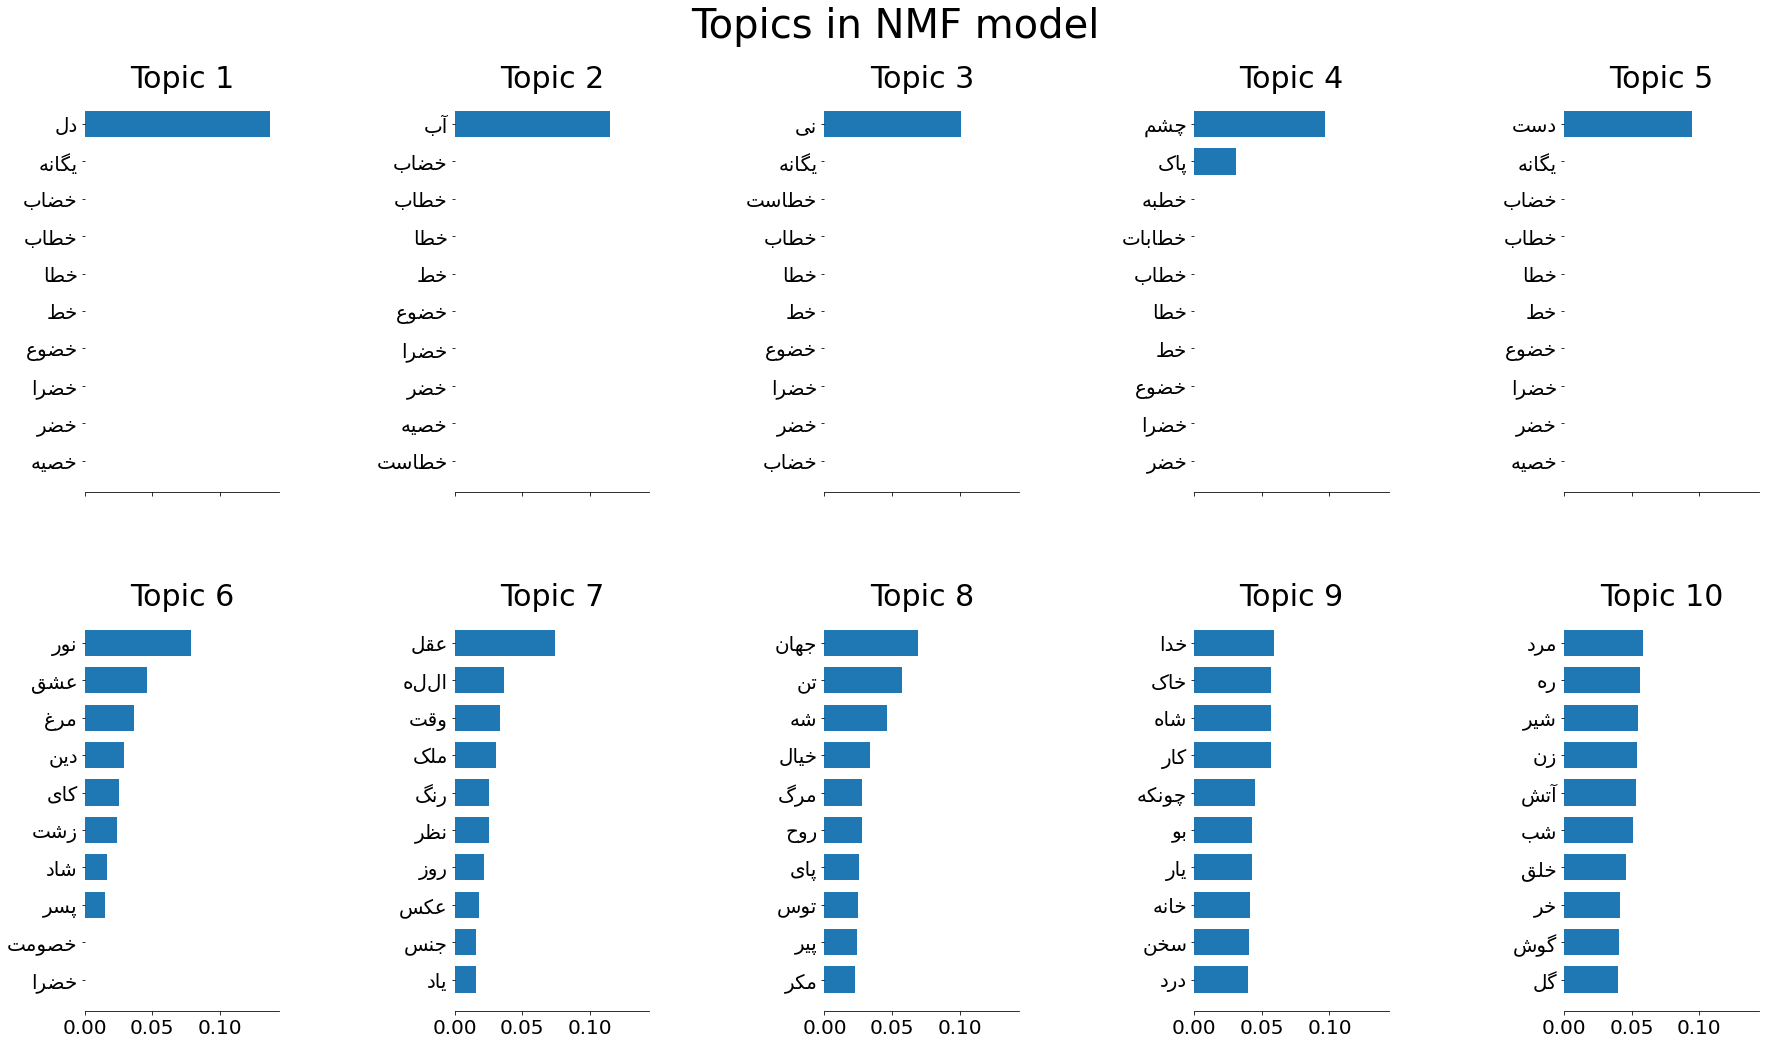

In [50]:
plot_top_words(
    nmf,
    tfidf_feature_names,
    10,
    "Topics in NMF model",
)

In [51]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [52]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [53]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [54]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [55]:
top_words = 10

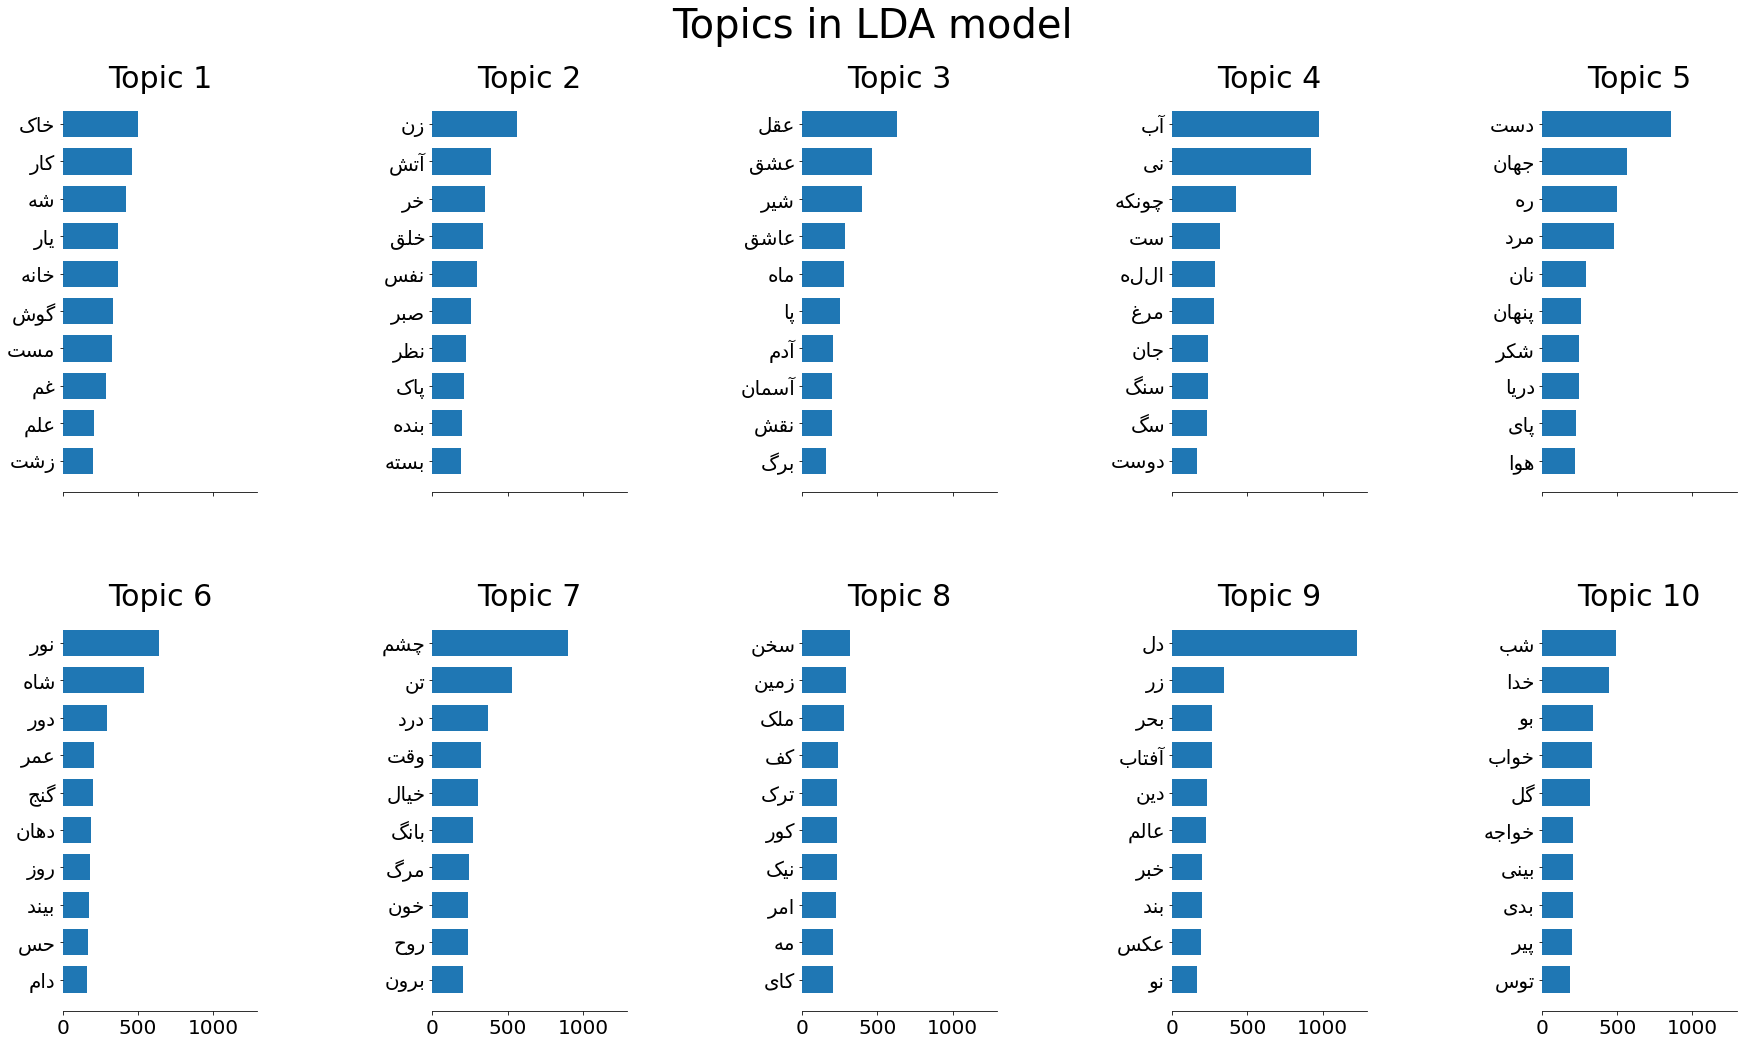

In [56]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")

### Plot frequent words by Daftar

In [57]:
freq_df = pd.DataFrame(columns=['index', 'Freq', 'Daftar'])
for i in range(1,7):
    freq_dict = nltk.FreqDist(chain(*masnavi_df[masnavi_df['Daftar'] == i]['Couplet_tokenized']))
    freq_dict = pd.DataFrame.from_dict(freq_dict, orient='index', columns=['Freq'])
    freq_dict['Daftar'] = [i] * freq_dict.shape[0]
    freq_dict.reset_index(level=0, inplace=True)
    freq_dict['index'] = freq_dict['index'].apply(lambda x: make_farsi_text(x))
    freq_df = pd.concat([freq_df, freq_dict])

In [58]:
freq_df = freq_df[freq_df['Freq']> 100]

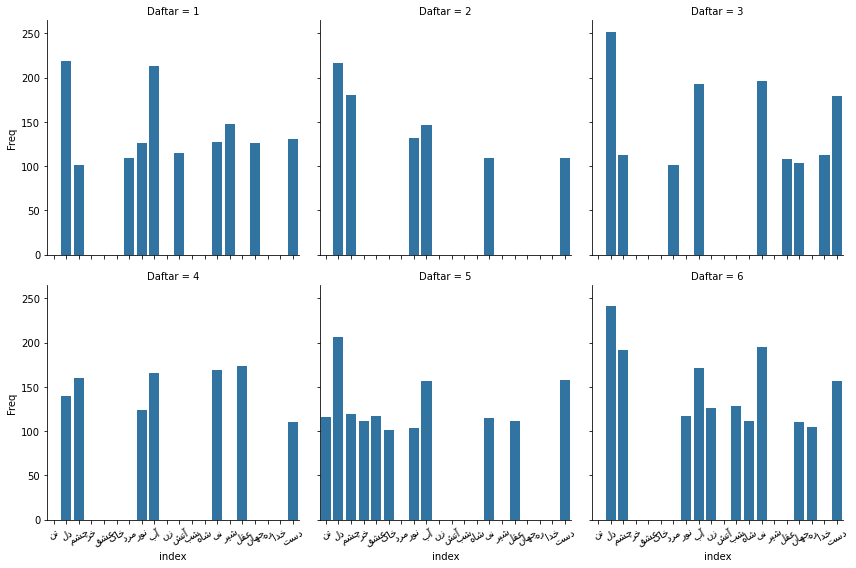

In [59]:
g = sns.FacetGrid(freq_df, col="Daftar", height=4, aspect=1, col_wrap=3)
g.set_xticklabels(rotation=30)
g.map(sns.barplot, "index", "Freq", order=list(set(freq_df['index'])))

### Topic Modeling

In [60]:
from gensim.test.utils import datapath
from pprint import pprint

In [61]:
dp_groups = masnavi_df.groupby(['Daftar'])

In [62]:
poems = []
for name, group in dp_groups:
    poems.append([t for l in group['Couplet_tokenized'] for t in l])

In [63]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=10000
)

In [64]:
tf = tf_vectorizer.fit_transform(poems[1])

In [65]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [66]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [67]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [68]:
tf_feature_names = [make_farsi_text(t) for t in tf_feature_names]

In [69]:
top_words = 10

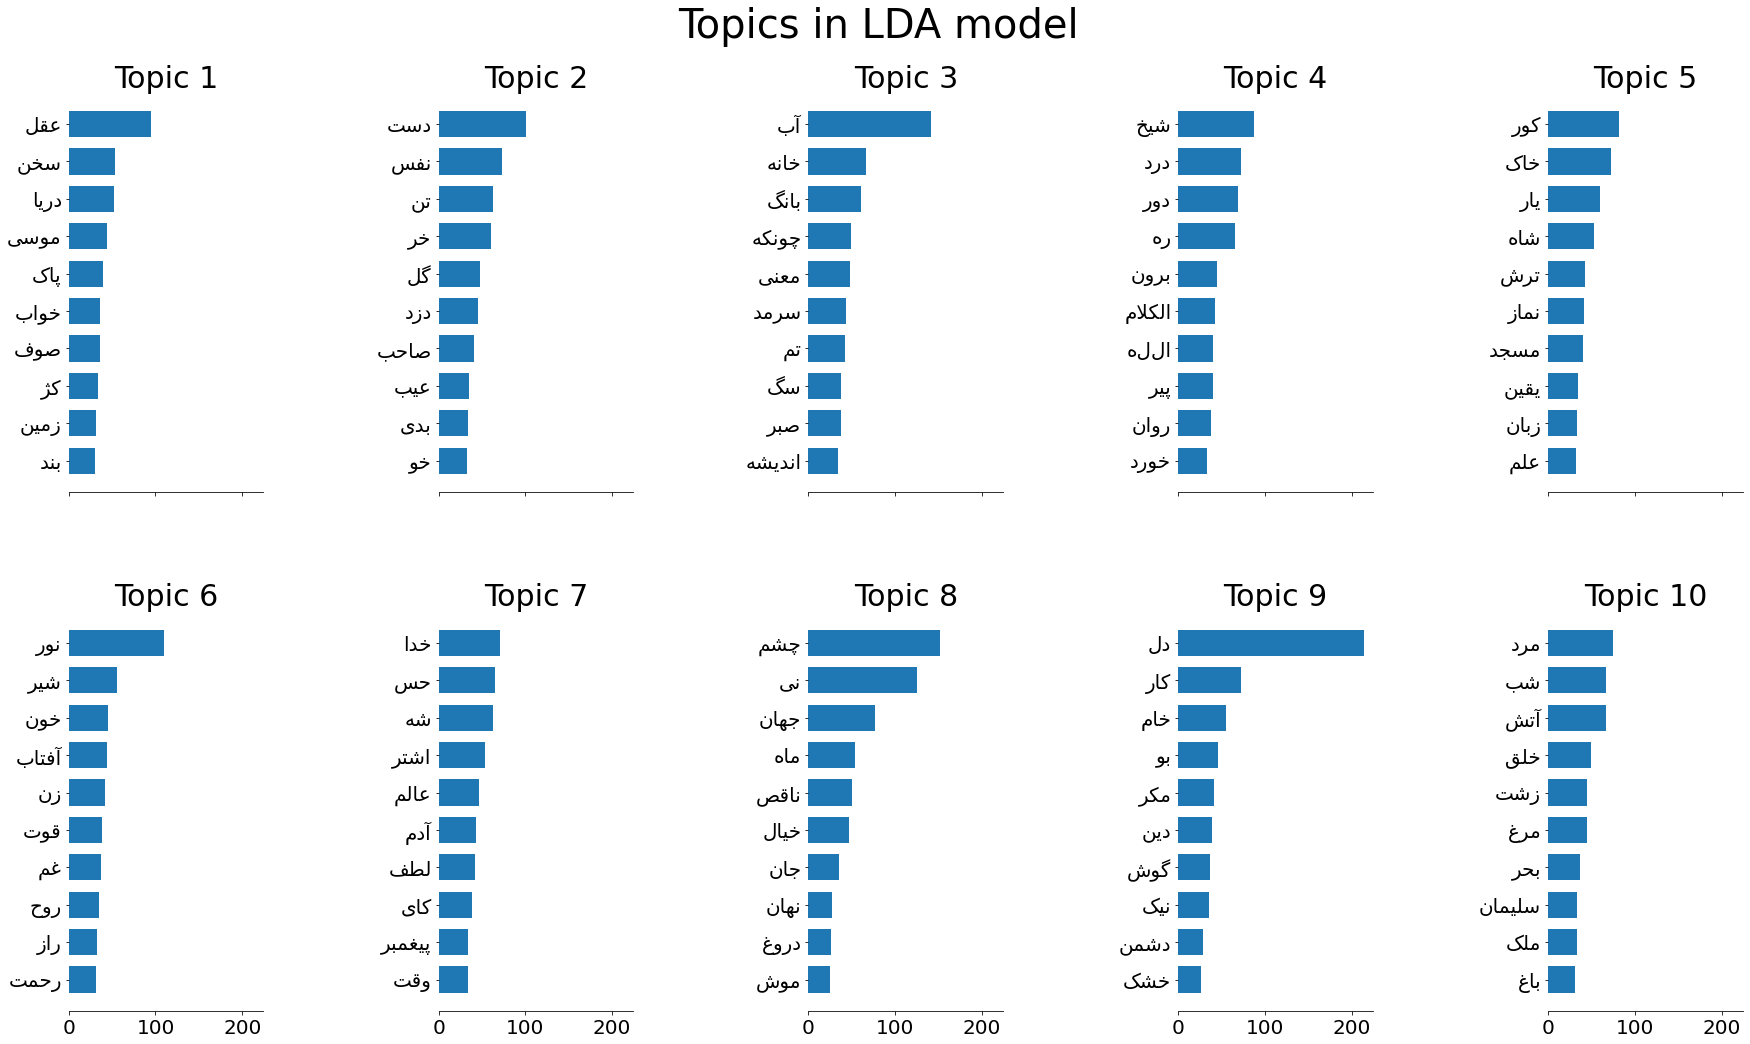

In [70]:
plot_top_words(lda, tf_feature_names, top_words, "Topics in LDA model")

In [72]:
from gensim.models import Phrases

In [73]:
bigram = Phrases(masnavi_df.CCouplet, min_count=1, threshold=2)

In [76]:
bigram['می','عشق','ناب','روزگار','وصل']

['می', 'عشق', 'ناب', 'روزگار', 'وصل']